<a href="https://colab.research.google.com/github/KrishnaChaitanya07/AIML/blob/main/handwritten_digit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import struct
import gzip
import os
import urllib.request
import matplotlib.pyplot as plt

In [3]:
# Download MNIST dataset if not present
def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
    if not os.path.exists(filename):
        print(f"Downloading {filename}...")
        urllib.request.urlretrieve(source + filename, filename)

In [4]:
def load_mnist_images(filename):
    download(filename)
    with gzip.open(filename, 'rb') as f:
        _, num, rows, cols = struct.unpack(">IIII", f.read(16))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows * cols) / 255.0

def load_mnist_labels(filename):
    download(filename)
    with gzip.open(filename, 'rb') as f:
        _, num = struct.unpack(">II", f.read(8))
        return np.frombuffer(f.read(), dtype=np.uint8)

def one_hot_encode(y, num_classes=10):
    return np.eye(num_classes)[y]


In [5]:

class NeuralNet:
    def __init__(self, input_size, hidden_size, output_size, lr=0.1):
        self.lr = lr
        self.w1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))
        self.w2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_deriv(self, x):
        return x * (1 - x)

    def softmax(self, x):
        exp = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp / np.sum(exp, axis=1, keepdims=True)

    def forward(self, x):
        self.z1 = np.dot(x, self.w1) + self.b1
        self.a1 = self.sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.w2) + self.b2
        self.a2 = self.softmax(self.z2)
        return self.a2

    def backward(self, x, y):
        m = y.shape[0]
        dz2 = self.a2 - y
        dw2 = np.dot(self.a1.T, dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m

        dz1 = np.dot(dz2, self.w2.T) * self.sigmoid_deriv(self.a1)
        dw1 = np.dot(x.T, dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m

        self.w1 -= self.lr * dw1
        self.b1 -= self.lr * db1
        self.w2 -= self.lr * dw2
        self.b2 -= self.lr * db2

    def loss(self, y_pred, y_true):
        return -np.sum(y_true * np.log(y_pred + 1e-8)) / y_true.shape[0]

In [7]:
# Download MNIST dataset if not present
def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
    if not os.path.exists(filename):
        print(f"Downloading {filename}...")
        # Updated URL to fix the 404 error
        updated_source = 'https://ossci-datasets.s3.amazonaws.com/mnist/'  # new source
        urllib.request.urlretrieve(updated_source + filename, filename)

Epoch 1/50 - Train Loss: 0.5453, Train Acc: 0.8250 - Val Loss: 0.3203, Val Acc: 0.9140
Epoch 2/50 - Train Loss: 0.2195, Train Acc: 0.9331 - Val Loss: 0.2612, Val Acc: 0.9320
Epoch 3/50 - Train Loss: 0.1457, Train Acc: 0.9571 - Val Loss: 0.2425, Val Acc: 0.9380
Epoch 4/50 - Train Loss: 0.1038, Train Acc: 0.9688 - Val Loss: 0.2333, Val Acc: 0.9420
Epoch 5/50 - Train Loss: 0.0776, Train Acc: 0.9781 - Val Loss: 0.2414, Val Acc: 0.9450
Epoch 6/50 - Train Loss: 0.0529, Train Acc: 0.9861 - Val Loss: 0.2158, Val Acc: 0.9500
Epoch 7/50 - Train Loss: 0.0393, Train Acc: 0.9908 - Val Loss: 0.2225, Val Acc: 0.9540
Epoch 8/50 - Train Loss: 0.0279, Train Acc: 0.9942 - Val Loss: 0.2189, Val Acc: 0.9550
Epoch 9/50 - Train Loss: 0.0209, Train Acc: 0.9970 - Val Loss: 0.2295, Val Acc: 0.9540
Early stopping triggered at epoch 9
Best Validation Accuracy: 0.9500 at epoch 6


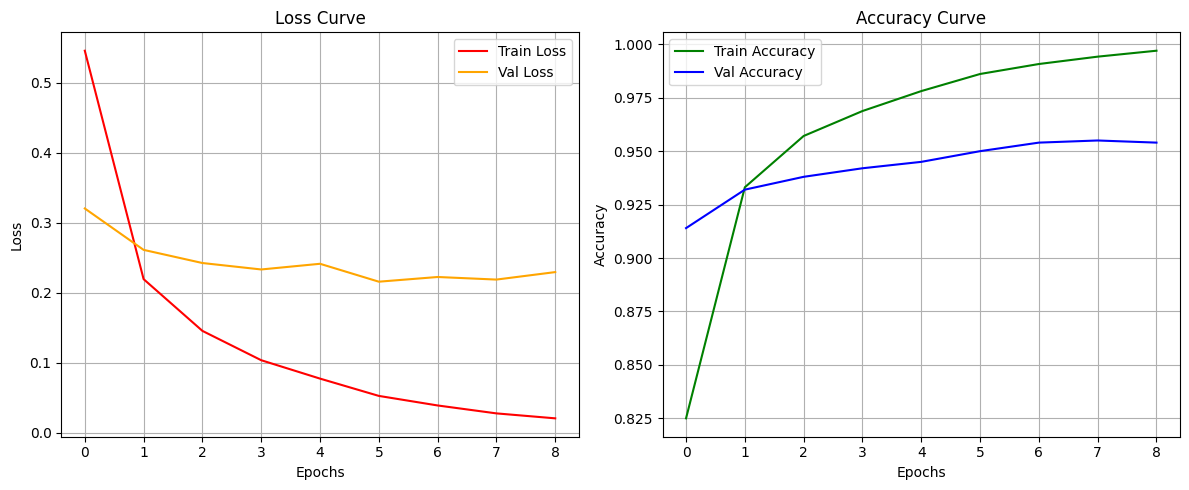

In [8]:
def main():
    # Load data
    train_images = load_mnist_images("train-images-idx3-ubyte.gz")[:10000]
    train_labels = load_mnist_labels("train-labels-idx1-ubyte.gz")[:10000]
    test_images = load_mnist_images("t10k-images-idx3-ubyte.gz")[:1000]
    test_labels = load_mnist_labels("t10k-labels-idx1-ubyte.gz")[:1000]

    train_labels_oh = one_hot_encode(train_labels)
    test_labels_oh = one_hot_encode(test_labels)

    # Split train into train + val
    val_ratio = 0.1
    val_size = int(len(train_images) * val_ratio)

    val_images = train_images[:val_size]
    val_labels_oh = train_labels_oh[:val_size]

    train_images = train_images[val_size:]
    train_labels_oh = train_labels_oh[val_size:]

    # Training parameters
    model = NeuralNet(784, 64, 10, lr=0.1)
    epochs = 50
    early_stopping_patience = 3

    losses = []
    accuracies = []
    val_losses = []
    val_accuracies = []

    best_val_loss = float('inf')
    best_epoch = 0
    best_val_accuracy = 0

    for epoch in range(epochs):
        # Training loop
        total_loss = 0
        correct = 0
        for i in range(len(train_images)):
            x = train_images[i].reshape(1, -1)
            y = train_labels_oh[i].reshape(1, -1)

            output = model.forward(x)
            loss = model.loss(output, y)
            model.backward(x, y)

            total_loss += loss
            if np.argmax(output) == np.argmax(y):
                correct += 1

        avg_loss = total_loss / len(train_images)
        accuracy = correct / len(train_images)
        losses.append(avg_loss)
        accuracies.append(accuracy)

        # Validation loop
        val_loss = 0
        val_correct = 0
        for i in range(len(val_images)):
            x = val_images[i].reshape(1, -1)
            y = val_labels_oh[i].reshape(1, -1)
            output = model.forward(x)
            loss = model.loss(output, y)
            val_loss += loss
            if np.argmax(output) == np.argmax(y):
                val_correct += 1

        avg_val_loss = val_loss / len(val_images)
        val_accuracy = val_correct / len(val_images)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {avg_loss:.4f}, Train Acc: {accuracy:.4f} - "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch
            best_val_accuracy = val_accuracy
        elif epoch - best_epoch >= early_stopping_patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    print(f"Best Validation Accuracy: {best_val_accuracy:.4f} at epoch {best_epoch+1}")

    # Plot training + validation loss and accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(losses, label='Train Loss', color='red')
    plt.plot(val_losses, label='Val Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Train Accuracy', color='green')
    plt.plot(val_accuracies, label='Val Accuracy', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("training_validation_metrics.png")
    plt.show()

if __name__ == "__main__":
    main()
